In [7]:
import pandas as pd
import numpy as np
import time
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime as dt
import math
from matplotlib import gridspec
from sklearn.metrics import accuracy_score



In [8]:
train = pd.read_csv('data/train.csv', parse_dates=['date'], index_col=['date'])
test = pd.read_csv('data/test.csv', parse_dates=['date'], index_col=['date'])
df_full = pd.concat([train,test])
df_full.index = pd.to_datetime(df_full.index)
#to display all valeues
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#   print(sales_a)

D:\CourseWork\Semester_3\Data science\Project\ds_env\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
train.head(10)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


In [10]:
train.tail(10)

,store,item,sales
date,,,
2017-12-22,10,50,75
2017-12-23,10,50,70
2017-12-24,10,50,76
2017-12-25,10,50,51
2017-12-26,10,50,41
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74
2017-12-30,10,50,62


In [56]:
pd.set_option('display.max_rows', 500)
pd.option_context("display.max_columns", 1000)
#startdate = train.index[0]
startdate = pd.to_datetime('January 1, 2013')
ns_per_day = 86400000000000
train_end_str = pd.to_datetime('August 3, 2017')
train_end_str2 = pd.to_datetime('April 1, 2018')

In [15]:
#splitting data column to multiple labels.
def split_df(df):
    data = df.copy()
    data['day_of_month'] = data.index.day
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['day_of_year'] = data.index.dayofyear  #((data.index - startdate)/ ns_per_day).astype(int) % 364
    data['day_of_week'] = data.index.dayofweek
    data['quarter'] = data.index.quarter  #(((data.index - startdate)/ ns_per_day).astype(int) // 91) % 4
    data['day_num'] = ((data.index - startdate)/ ns_per_day).astype(int) +1
    data['day_of_quarter'] = ((data.index - startdate)/ ns_per_day).astype(int) % 91
    #print (data.index)
    return data

def add_means(df,end):
    data1 = df
    data1.reset_index(inplace=True)

    # Add average by item by store by day of year as additional feature
    avg = data1.loc[df['date'] < pd.to_datetime(end), ['day_of_year','sales','store','item']].groupby(by=['day_of_year','store','item']).mean().reset_index()
    avg.columns =['day_of_year','store','item','DoY_Mean']
    data1 = data1.merge(avg, on=['day_of_year','store','item'])
    
    # Add average by day of week by quarter by item by store as additional feature
    avg = data1.loc[df['date'] < pd.to_datetime(end), ['quarter','day_of_week','sales','store','item']].groupby(by=['quarter','day_of_week','store','item']).mean().reset_index()
    avg.columns =['quarter','day_of_week','store','item','DoW_Mean']
    data1 = data1.merge(avg, on=['quarter','day_of_week','store','item'])
    # Id's start at 0 instead of 1
    data1['store'] -=1
    data1['item'] -=1
    # Remove first year of data as there is no prior year sales for them, then sort to match competition id's
    data1 = data1[data1['year'] >=0].drop('year', axis=1).sort_values(['item','store','date'])
    return data1
  
    
data = split_df(train)
data_test = split_df(test)
data2 = add_means(data, 'August 3, 2017')
data2_test = add_means(data_test,'April 1, 2018')


D:\CourseWork\Semester_3\Data science\Project\ds_env\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [16]:
data.set_index('date')

,store,item,sales,day_of_month,month,year,day_of_year,day_of_week,quarter,day_num,day_of_quarter
date,,,,,,,,,,,
2013-01-01,1,1,13,1,1,2013,1,1,1,1,0
2013-01-02,1,1,11,2,1,2013,2,2,1,2,1
2013-01-03,1,1,14,3,1,2013,3,3,1,3,2
2013-01-04,1,1,13,4,1,2013,4,4,1,4,3
2013-01-05,1,1,10,5,1,2013,5,5,1,5,4
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,10,50,63,27,12,2017,361,2,4,1822,1
2017-12-28,10,50,59,28,12,2017,362,3,4,1823,2
2017-12-29,10,50,74,29,12,2017,363,4,4,1824,3


In [17]:
data2_test.tail(100)

,date,id,store,item,day_of_month,month,day_of_year,day_of_week,quarter,day_num,day_of_quarter,DoY_Mean,DoW_Mean
44870,2018-03-22,44900,8,49,22,3,81,3,1,1907,86,NaN,NaN
44883,2018-03-23,44901,8,49,23,3,82,4,1,1908,87,NaN,NaN
44896,2018-03-24,44902,8,49,24,3,83,5,1,1909,88,NaN,NaN
44909,2018-03-25,44903,8,49,25,3,84,6,1,1910,89,NaN,NaN
44832,2018-03-26,44904,8,49,26,3,85,0,1,1911,90,NaN,NaN
44845,2018-03-27,44905,8,49,27,3,86,1,1,1912,0,NaN,NaN
44858,2018-03-28,44906,8,49,28,3,87,2,1,1913,1,NaN,NaN
44871,2018-03-29,44907,8,49,29,3,88,3,1,1914,2,NaN,NaN
44884,2018-03-30,44908,8,49,30,3,89,4,1,1915,3,NaN,NaN
44897,2018-03-31,44909,8,49,31,3,90,5,1,1916,4,NaN,NaN


In [18]:
train.store.unique()
train.index.unique()

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='date', length=1826, freq=None)

# Yearly Trends

date
2013-01-01     12.0
2013-01-01     43.0
2013-01-01     45.0
2013-01-01     51.0
2013-01-01     17.0
              ...  
2017-12-31     97.0
2017-12-31    104.0
2017-12-31     30.0
2017-12-31     77.0
2017-12-31     73.0
Name: sales, Length: 91300, dtype: float64


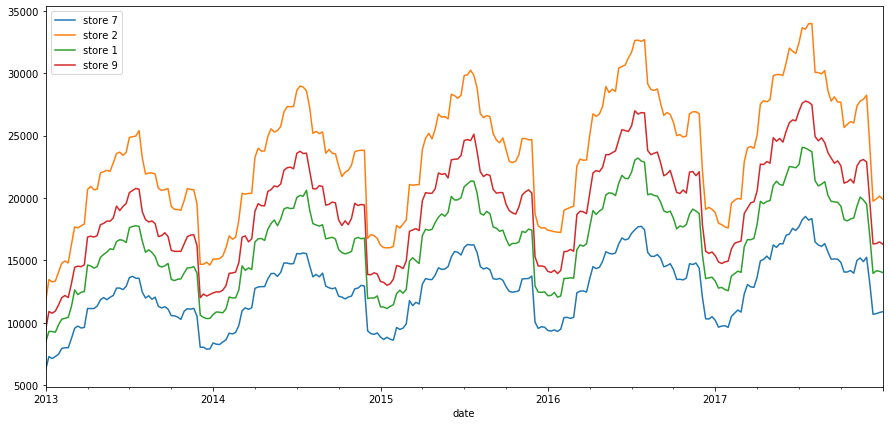

In [19]:
#chckgin different store sales in the past 5 years 
train['sales'] = train['sales'] * 1.0

# store types
sales_7 = train[train.store == 7]['sales'].sort_index(ascending = True)
sales_2 = train[train.store == 2]['sales'].sort_index(ascending = True) 
sales_1 = train[train.store == 1]['sales'].sort_index(ascending = True)
sales_9 = train[train.store == 9]['sales'].sort_index(ascending = True)
#print (sales_2)
#plot store types
f, ax = plt.subplots(1, figsize = (15, 7))
sales_7.resample('W').sum().plot(label ="store 7").legend()
sales_2.resample('W').sum().plot(label ="store 2").legend()
sales_1.resample('W').sum().plot(label ="store 1").legend()
sales_9.resample('W').sum().plot(label ="store 9").legend()


### Yearly data split
We check yearly sales of store 2 

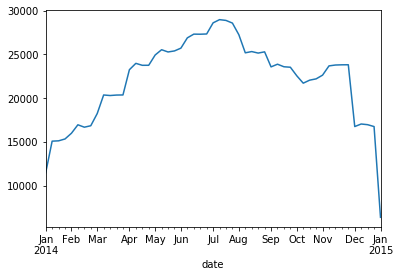

In [58]:
sales_2014['sales'].resample('W').sum().plot()


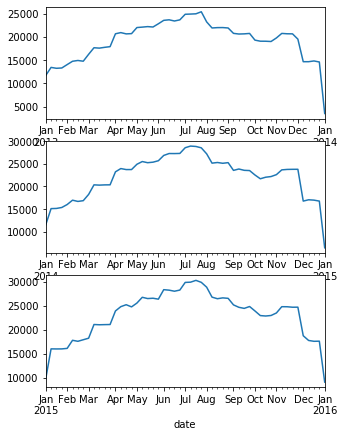

In [20]:
# we put store 2 dat in a dataframe for better access
type(sales_2)
sales_2_df = pd.DataFrame(sales_2)
#splitting data with respect to years
#sales_2_df['year'] =sales_2_df.index.to_series().dt.year
#sales_2_df.groupby('year').count()
sales_2013 = sales_2_df[:18249]
sales_2014 = sales_2_df[18250:(18250+18249)]
sales_2015 = sales_2_df[(18250+18250):(18250+18250+18249)]
#plot
f, (ax1,ax2,ax3)  = plt.subplots(3, figsize = (5, 7))
sales_2013['sales'].resample('W').sum().plot(ax=ax1)
sales_2014['sales'].resample('W').sum().plot(ax=ax2)
sales_2015['sales'].resample('W').sum().plot(ax=ax3)

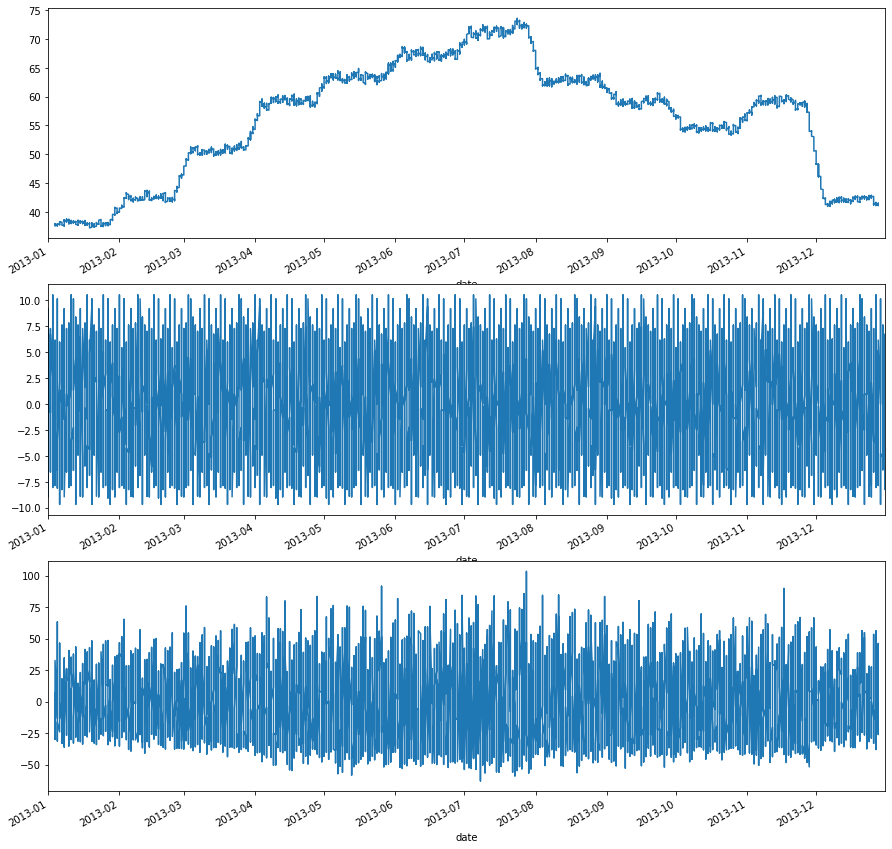

In [21]:
f, (ax1, ax2, ax3) = plt.subplots(3, figsize = (15, 16))
decomposition_a = sm.tsa.seasonal_decompose(sales_2013['sales'], model = 'additive', freq = 365)
decomposition_a.trend.plot(ax = ax1)
decomposition_a.seasonal.plot(ax = ax2)
decomposition_a.resid.plot(ax = ax3)

### Weekly Trends
We check weekly sales of store 2

In [22]:
data[data.store == 2].sort_values("day_num")

,date,store,item,sales,day_of_month,month,year,day_of_year,day_of_week,quarter,day_num,day_of_quarter
1826,2013-01-01,2,1,12,1,1,2013,1,1,1,1,0
823526,2013-01-01,2,46,43,1,1,2013,1,1,1,1,0
494846,2013-01-01,2,28,45,1,1,2013,1,1,1,1,0
184426,2013-01-01,2,11,51,1,1,2013,1,1,1,1,0
476586,2013-01-01,2,27,17,1,1,2013,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
514931,2017-12-31,2,29,97,31,12,2017,365,6,4,1826,5
496671,2017-12-31,2,28,104,31,12,2017,365,6,4,1826,5
478411,2017-12-31,2,27,30,31,12,2017,365,6,4,1826,5
423631,2017-12-31,2,24,77,31,12,2017,365,6,4,1826,5


In [23]:
sales2a_df = data[data.store == 2]
sales2a_df['day_of_week'] = sales2a_df['day_of_week'].map({1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun', 0: 'Mon'})
sales_w_2013 = sales2a_df[sales2a_df.year==2013]
sales_w_2014 = sales2a_df[sales2a_df.year==2014]
sales_w_2015 = sales2a_df[sales2a_df.year==2015]
sales_w_2016 = sales2a_df[sales2a_df.year==2016]

D:\CourseWork\Semester_3\Data science\Project\ds_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
sales_w_2015

,date,store,item,sales,day_of_month,month,year,day_of_year,day_of_week,quarter,day_num,day_of_quarter
2556,2015-01-01,2,1,20,1,1,2015,1,Thu,1,731,2
2557,2015-01-02,2,1,17,2,1,2015,2,Fri,1,732,3
2558,2015-01-03,2,1,26,3,1,2015,3,Sat,1,733,4
2559,2015-01-04,2,1,24,4,1,2015,4,Sun,1,734,5
2560,2015-01-05,2,1,10,5,1,2015,5,Mon,1,735,6
...,...,...,...,...,...,...,...,...,...,...,...,...
897656,2015-12-27,2,50,78,27,12,2015,361,Sun,4,1091,89
897657,2015-12-28,2,50,46,28,12,2015,362,Mon,4,1092,90
897658,2015-12-29,2,50,58,29,12,2015,363,Tue,4,1093,0
897659,2015-12-30,2,50,69,30,12,2015,364,Wed,4,1094,1


In [25]:
sales_w_2013[0:0+7]['day_of_week']

1826    Tue
1827    Wed
1828    Thu
1829    Fri
1830    Sat
1831    Sun
1832    Mon
Name: day_of_week, dtype: object

<Figure size 432x288 with 0 Axes>

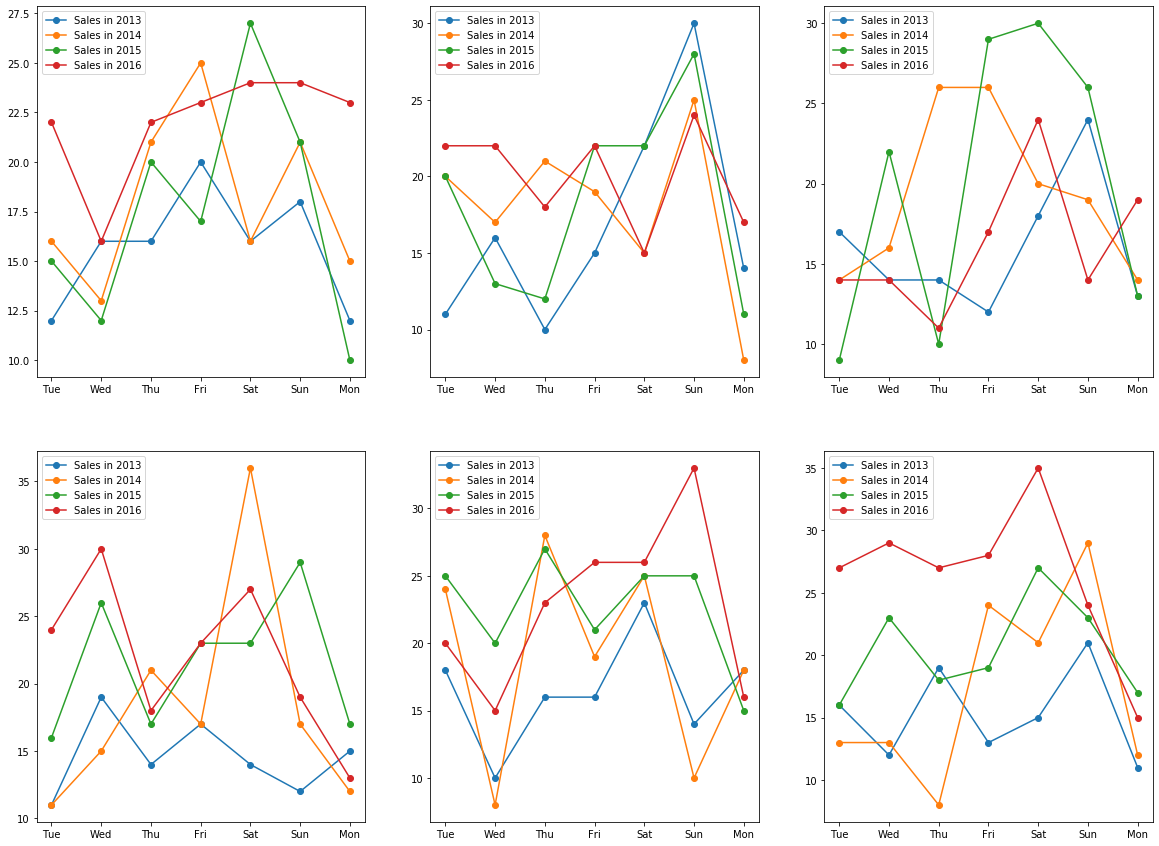

In [26]:
fig = plt.figure()
N = 6
weeks = 6
f, axs = plt.subplots(2,3, figsize=(20,15))
for i,j in zip(range(0,7*weeks,7), range(1,N+1)):
    plt.subplot(2,3, j)
    plt.plot(sales_w_2013[i:i+7]['day_of_week'].values, sales_w_2013[i:i+7]['sales'].values, '-o', label = 'Sales in 2013', linestyle='-' )
    plt.plot(sales_w_2014[i+6:i+7+6]['day_of_week'].values, sales_w_2014[i+6:i+7+6]['sales'].values, '-o',  label = 'Sales in 2014', linestyle='-')
    plt.plot(sales_w_2015[i+5:i+7+5]['day_of_week'].values, sales_w_2015[i+5:i+7+5]['sales'].values, '-o', label = 'Sales in 2015' , linestyle='-')
    plt.plot(sales_w_2016[i+4:i+7+4]['day_of_week'].values, sales_w_2016[i+4:i+7+4]['sales'].values, '-o',  label = 'Sales in 2016', linestyle='-')
    plt.legend()
plt.show()


### Monthly Data Split
We check monthly sales of store 2

In [27]:
sales_jan_2013 = sales_w_2013[sales_w_2013.month ==1]
sales_feb_2013 = sales_w_2013[sales_w_2013.month ==2]
sales_mar_2013 = sales_w_2013[sales_w_2013.month ==3]
sales_april_2013 = sales_w_2013[sales_w_2013.month ==4]
sales_may_2013 = sales_w_2013[sales_w_2013.month ==5]
sales_jun_2013 = sales_w_2013[sales_w_2013.month ==6]
sales_jul_2013 = sales_w_2013[sales_w_2013.month ==7]
sales_aug_2013 = sales_w_2013[sales_w_2013.month ==8]
sales_sept_2013 = sales_w_2013[sales_w_2013.month ==9]
sales_oct_2013 = sales_w_2013[sales_w_2013.month ==10]
sales_nov_2013 = sales_w_2013[sales_w_2013.month ==11]
sales_dec_2013 = sales_w_2013[sales_w_2013.month ==12]
months_2013 = [sales_jan_2013, sales_feb_2013, sales_mar_2013, sales_april_2013, sales_may_2013 , sales_jun_2013, sales_jul_2013, sales_aug_2013, sales_sept_2013, sales_oct_2013, sales_nov_2013, sales_dec_2013]

sales_jan_2014 = sales_w_2014[sales_w_2014.month ==1]
sales_feb_2014 = sales_w_2014[sales_w_2014.month ==2]
sales_mar_2014 = sales_w_2014[sales_w_2014.month ==3]
sales_april_2014 = sales_w_2014[sales_w_2014.month ==4]
sales_may_2014 = sales_w_2014[sales_w_2014.month ==5]
sales_jun_2014 = sales_w_2014[sales_w_2014.month ==6]
sales_jul_2014 = sales_w_2014[sales_w_2014.month ==7]
sales_aug_2014 = sales_w_2014[sales_w_2014.month ==8]
sales_sept_2014 = sales_w_2014[sales_w_2014.month ==9]
sales_oct_2014 = sales_w_2014[sales_w_2014.month ==10]
sales_nov_2014 = sales_w_2014[sales_w_2014.month ==11]
sales_dec_2014 = sales_w_2014[sales_w_2014.month ==12]
months_2014 = [sales_jan_2014, sales_feb_2014, sales_mar_2014, sales_april_2014, sales_may_2014 , sales_jun_2014, sales_jul_2014, sales_aug_2014, sales_sept_2014, sales_oct_2014, sales_nov_2014, sales_dec_2014]

sales_jan_2014 = sales_jan_2014.set_index('date')
sales_feb_2014 = sales_feb_2014.set_index('date')
sales_mar_2014 = sales_mar_2014.set_index('date')
sales_april_2014 = sales_april_2014.set_index('date')
sales_may_2014= sales_may_2014.set_index('date')
sales_jun_2014 = sales_jun_2014.set_index('date')
sales_jul_2014 = sales_jul_2014.set_index('date')
sales_aug_2014 = sales_aug_2014.set_index('date')
sales_sept_2014 =sales_sept_2014.set_index('date')
sales_oct_2014 = sales_oct_2014.set_index('date')
sales_nov_2014 = sales_nov_2014.set_index('date')
sales_dec_2014 = sales_dec_2014.set_index('date')

In [28]:
sales_nov_2014

,store,item,sales,day_of_month,month,year,day_of_year,day_of_week,quarter,day_num,day_of_quarter
date,,,,,,,,,,,
2014-11-01,2,1,35,1,11,2014,305,Sat,4,670,32
2014-11-02,2,1,30,2,11,2014,306,Sun,4,671,33
2014-11-03,2,1,20,3,11,2014,307,Mon,4,672,34
2014-11-04,2,1,25,4,11,2014,308,Tue,4,673,35
2014-11-05,2,1,27,5,11,2014,309,Wed,4,674,36
...,...,...,...,...,...,...,...,...,...,...,...
2014-11-26,2,50,77,26,11,2014,330,Wed,4,695,57
2014-11-27,2,50,110,27,11,2014,331,Thu,4,696,58
2014-11-28,2,50,90,28,11,2014,332,Fri,4,697,59


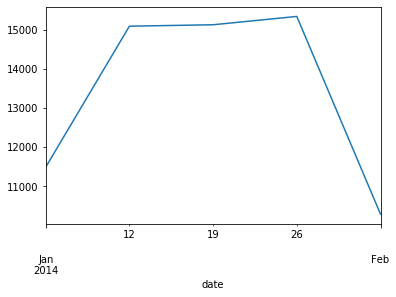

In [29]:
sales_jan_2014['sales'].resample('W').sum().plot()

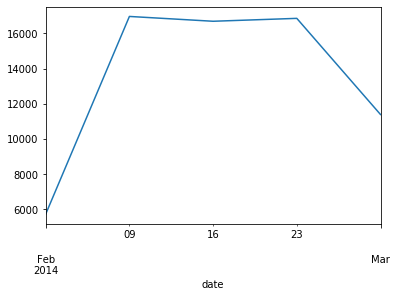

In [30]:
sales_feb_2014['sales'].resample('W').sum().plot()

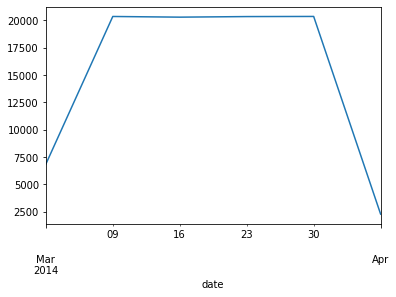

In [31]:
sales_mar_2014['sales'].resample('W').sum().plot()

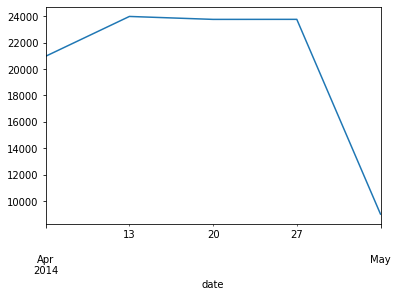

In [32]:
sales_april_2014['sales'].resample('W').sum().plot()

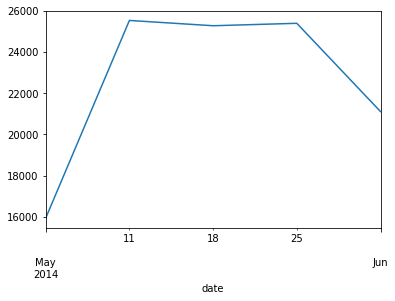

In [33]:
sales_may_2014['sales'].resample('W').sum().plot()

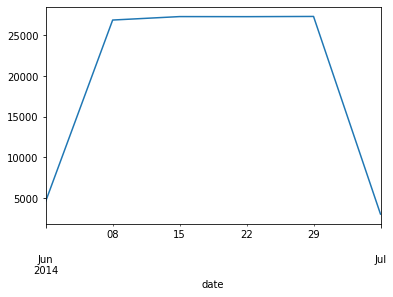

In [34]:
sales_jun_2014['sales'].resample('W').sum().plot()

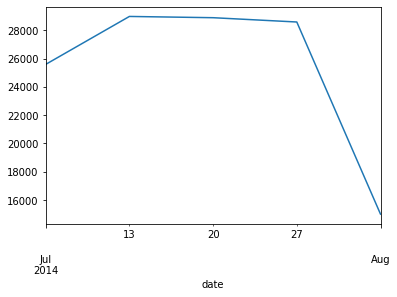

In [35]:
sales_jul_2014['sales'].resample('W').sum().plot()

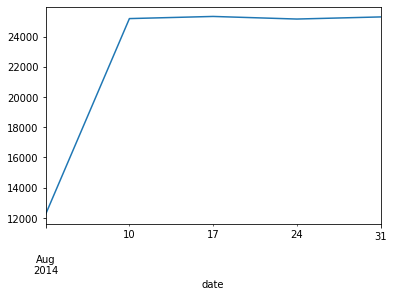

In [36]:

sales_aug_2014['sales'].resample('W').sum().plot()

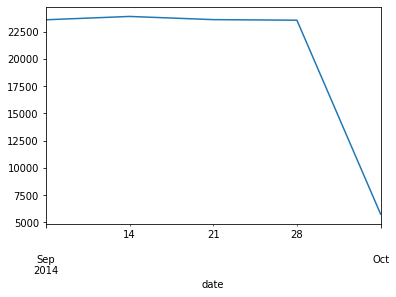

In [37]:
sales_sept_2014['sales'].resample('W').sum().plot()

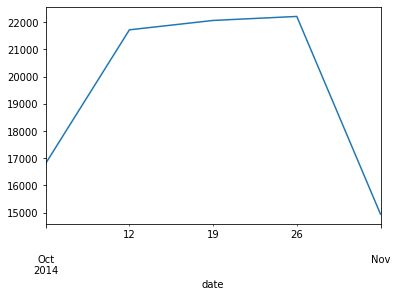

In [38]:
sales_oct_2014['sales'].resample('W').sum().plot()

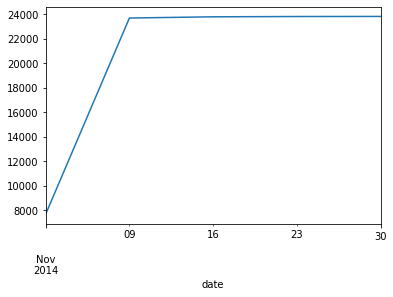

In [39]:
sales_nov_2014['sales'].resample('W').sum().plot()

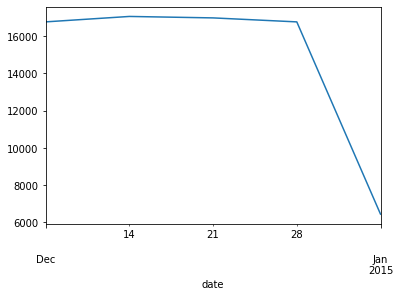

In [40]:
sales_dec_2014['sales'].resample('W').sum().plot()

### Prediction

In [44]:
def xboost(x_train, y_train, x_test):
    dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=list(x_train.columns))
    dtest = xgb.DMatrix(x_test, feature_names=list(x_test.columns))

    params = {'max_depth':3,
              'eta':0.2,
              'silent':1,
              'subsample':1}
    num_rounds = 1500

    bst = xgb.train(params, dtrain, num_rounds)
    
    return pd.Series(bst.predict(dtest))

In [45]:
def SMAPE (forecast, actual):
    masked_arr = ~((forecast==0)&(actual==0))
    diff = abs(forecast[masked_arr] - actual[masked_arr])
    avg = (abs(forecast[masked_arr]) + abs(actual[masked_arr]))/2
    print('SMAPE Error Score: ' + str(round(sum(diff/avg)/len(forecast) * 100, 2)) + ' %')
    return round(sum(diff/avg)/len(forecast) * 100, 2)

In [46]:
x_train = data2.loc[train.index < pd.to_datetime('August 3, 2017')].drop(['sales','date','day_of_month', 'day_of_week'], axis=1)
y_train = data2.loc[train.index < pd.to_datetime('August 3, 2017'), 'sales']
x_test = data2.loc[train.index >= pd.to_datetime('August 3, 2017')].drop(['sales','date','day_of_month', 'day_of_week'], axis=1).reset_index(drop=True)
y_test = data2.loc[train.index >= pd.to_datetime('August 3, 2017'), 'sales'].reset_index(drop=True)

In [54]:
x_train.sample(10)

,store,item,month,day_of_year,quarter,day_num,day_of_quarter,DoY_Mean,DoW_Mean
559400,6,30,6,179,2,1640,1,48.40,43.338462
168384,2,9,1,9,1,1470,13,49.80,52.203125
638985,9,34,10,297,4,1027,25,75.25,82.318182
349571,1,19,5,132,2,1593,45,72.00,72.615385
368810,1,20,11,307,4,672,34,45.25,42.863636
310673,0,17,3,85,1,1180,87,70.40,63.646154
176052,6,9,6,155,2,885,65,64.40,58.107692
320128,5,17,6,178,2,1639,0,84.80,64.769231
824721,1,45,8,218,3,948,37,75.50,85.953846
399765,8,21,10,277,4,642,4,74.00,92.659091


In [48]:
preds = xboost(x_train, y_train, x_test)
error_score = SMAPE(preds, y_test)


D:\CourseWork\Semester_3\Data science\Project\ds_env\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


SMAPE Error Score: 14.3 %


In [49]:
accuracy = 100-error_score
accuracy

85.7

In [50]:
y_test_df = pd.DataFrame(y_test)
y_test_df.head(10)

,sales
0,25
1,26
2,35
3,29
4,20
5,28
6,28
7,31
8,25
9,32


In [51]:
preds_df = pd.DataFrame(preds)
preds_df.head(10)

,0
0,26.540703
1,30.415768
2,30.095602
3,28.292131
4,18.914976
5,25.432817
6,23.085438
7,23.679829
8,26.378744
9,26.053070
